**Cylindrical Thermal Convection**

Compared to *Effects of Curvature on Two-Dimensional Models of Mantle Convection: Cylindrical Polar Coordinates* (Jarvis, 1993)

Jarvis found relationships for Nu and average temperature with the cylindrical mesh geometry, specifically the ratio of outer to inner radii, f.

**Limitations:** The models of Jarvis have free outer and inner surfaces, whereas these are fixed in this model

In [1]:
# Model parameters
res_radial,res_angular = 40,150
maxtimesteps           = 1
outputPath             = 'Jarvis_output/'

# Whether or not to start from the previous temperature field
loaddata = True
load_temp_filename='Jarvis93data/temperature-1950.h5'


In [2]:
import underworld as uw
import glucifer
import numpy as np
from underworld import function as fn
uw.matplotlib_inline()
import math

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: mpi4py.MPI.Win size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  return f(*args, **kwds)


In [3]:
import matplotlib.pyplot as plt
plt.ion()

In [5]:
def checkpoint(mesh,fieldDict,swarm,swarmDict,index,modeltime=None,meshName="mesh",swarmName="swarm",prefix="./",enable_xdmf=True,):
    # Check the prefix is valid
    if prefix is not None:
        if not prefix.endswith("/"):
            prefix += "/"  # add a backslash
        if not os.path.exists(prefix) and uw.mpi.rank == 0:
            print("Creating directory: ", prefix)
            os.makedirs(prefix)

    uw.mpi.barrier()

    if not isinstance(index, int):
        raise TypeError("'index' is not of type int")
    if modeltime is not None:
        time = modeltime
    else:
        time = index

    ii = str(index).zfill(5)

    if mesh is not None:

        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if not isinstance(fieldDict, dict):
            raise TypeError("'fieldDict' is not of type dict")
        for key, value in fieldDict.items():
            if not isinstance(value, uw.mesh.MeshVariable):
                raise TypeError(
                    "'fieldDict' must contain uw.mesh.MeshVariable elements"
                )

        # see if we have already saved the mesh. It only needs to be saved once
        if not hasattr(checkpoint, "mH"):
            checkpoint.mH = mesh.save(prefix + meshName + ".h5")
        mh = checkpoint.mH

        for key, value in fieldDict.items():
            filename = prefix + key + "-" + ii
            handle = value.save(filename + ".h5")
            if enable_xdmf:
                value.xdmf(filename, handle, key, mh, meshName, modeltime=time)

    # is there a swarm
    if swarm is not None:

        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if not isinstance(swarmDict, dict):
            raise TypeError("'swarmDict' is not of type dict")
        for key, value in swarmDict.items():
            if not isinstance(value, uw.swarm.SwarmVariable):
                raise TypeError(
                    "'fieldDict' must contain uw.swarm.SwarmVariable elements"
                )

        sH = swarm.save(prefix + swarmName + "-" + ii + ".h5")
        for key, value in swarmDict.items():
            filename = prefix + key + "-" + ii
            handle = value.save(filename + ".h5")
            if enable_xdmf:
                value.xdmf(filename, handle, key, sH, swarmName, modeltime=time)

In [6]:
annulus = uw.mesh.FeMesh_Annulus(elementRes=(res_radial,res_angular), 
                                  radialLengths=(0.4292,1.4292), angularExtent=(0.,360.),
                                  periodic = [False, True])


tField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)
vField = uw.mesh.MeshVariable(annulus, nodeDofCount=2)
pField = uw.mesh.MeshVariable(annulus.subMesh, nodeDofCount=1)

In [7]:
Ra = 1e5


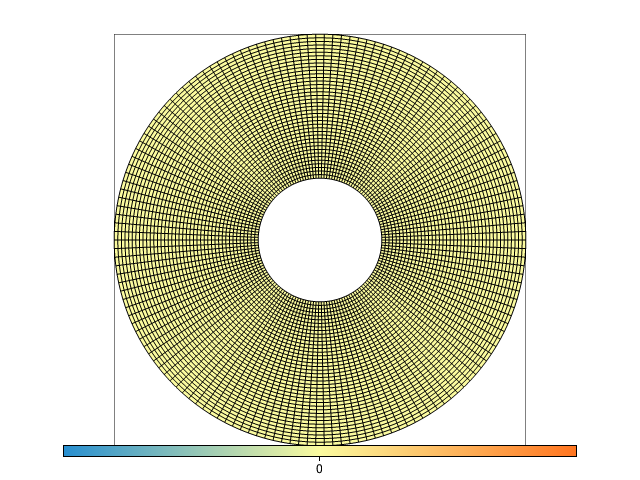

In [10]:
fig = glucifer.Figure()
fig.append(glucifer.objects.Mesh(annulus, segmentsPerEdge=1))
fig.append(glucifer.objects.Surface(annulus, tField, onMesh=True ))
fig.show()

In [11]:
t_outer = 0.0
t_inner = 1.0

outer = annulus.specialSets["MaxI_VertexSet"]
inner = annulus.specialSets["MinI_VertexSet"]
boundaryNodes = outer+inner

In [13]:
# setup parameters for temperature distribution
dr = annulus.radialLengths[1] - annulus.radialLengths[0]
dT_dr = (t_outer-t_inner)/(dr)
c0 = t_inner - dT_dr*annulus.radialLengths[0]

# wavenumber for perturbation
k = 4.0

for ind,coord in enumerate(annulus.data):
    r = np.sqrt(coord[0]**2 + coord[1]**2)
    theta = np.arctan2(coord[1], coord[0])
    
    pert = 0.2 *np.sin(k*theta)
    
    t = r*dT_dr + c0
    tField.data[ind] = min([max([0.,t + 1.*pert]),1])
    
tField.data[inner.data] = t_inner
tField.data[outer.data] = t_outer

if loaddata:
    tField.load(load_temp_filename ,interpolate=False)

In [14]:
# A hacky  way to import data from a different resolution, as the loaddata interpolation
# doesn't like the inner and outer surfaces of the cylindrical geometry
importlowres = False

if importlowres:
    tempannulus = uw.mesh.FeMesh_Annulus(elementRes=(32,64), 
                                      radialLengths=(0.4292,1.4292), angularExtent=(0.,360.),
                                      periodic = [False, True])
    tempTfield = uw.mesh.MeshVariable(tempannulus, nodeDofCount=1)
    tempTfield.load('Jarvis93data/temperature-350.h5', interpolate=True)

    for node in range(annulus.nodesGlobal):
        pos = annulus.data[node]
        if node not in inner and node not in outer:
            tField.data[node] = tempTfield.evaluate(tuple(pos))



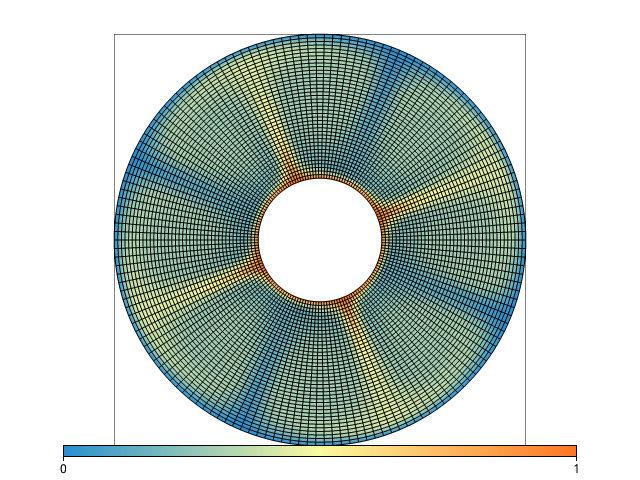

In [15]:
fig.show()

In [16]:
# mH = annulus.save('mesh.h5')
# tH = tField.save('Jarvis93data/temperature-350.h5', mH)

In [17]:
tBC = uw.conditions.DirichletCondition( variable=tField, indexSetsPerDof=(inner+outer))
vBC = uw.conditions.RotatedDirichletCondition( 
                                    variable        = vField,
                                    indexSetsPerDof = (inner+outer, None),
                                    basis_vectors   = (annulus.bnd_vec_normal, annulus.bnd_vec_tangent))

In [18]:
tDotField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)
advDiffSLE = uw.systems.AdvectionDiffusion(tField, tDotField, vField, fn_diffusivity=1.0, conditions=tBC)

In [27]:
# g  = 1.0*annulus.fn_unitvec_radial()
g  = 1.0*annulus.unitvec_r_Fn

In [28]:
bodyForceFn = g * tField * Ra / (annulus.radialLengths[1]-annulus.radialLengths[0])


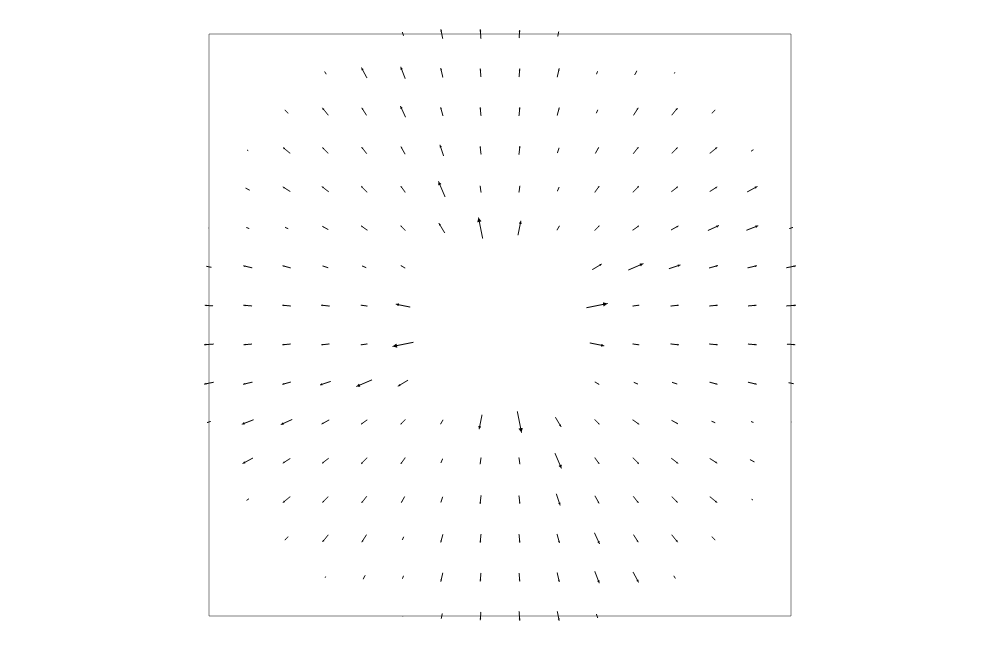

In [32]:
figVdot = glucifer.Figure(store=None,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
figVdot.append( glucifer.objects.VectorArrows( annulus,bodyForceFn))
figVdot.show()

In [29]:
stokesSLE = uw.systems.Stokes(vField, pField, 
                              fn_viscosity=1.0, 
                              fn_bodyforce=bodyForceFn, 
                              conditions=vBC, 
                              _removeBCs=False)

In [18]:
def removeNullSpace():
    mesh = annulus
    r = fn.math.sqrt(fn.math.pow(fn.coord()[0],2.) + fn.math.pow(fn.coord()[1],2.))
    tang = r*mesh.fn_unitvec_tangent()

    # build solid body rotation vector
    stokesSLE._vnsVec.meshVariable.data[:] = tang.evaluate(mesh) # evaluate
    uw.libUnderworld.StgFEM.SolutionVector_LoadCurrentFeVariableValuesOntoVector(stokesSLE._vnsVec._cself) #store

    # subtract from velocity continue
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(stokesSLE._velocitySol._cself, stokesSLE._vnsVec._cself)
    
def realignSolution(): 
    # re-rotate and unmix
    uw.libUnderworld.Underworld.AXequalsX( stokesSLE._rot._cself, stokesSLE._velocitySol._cself, False)
    
def postSolve():
    realignSolution()
    removeNullSpace()

In [19]:
stokesSolver = uw.systems.Solver(stokesSLE)

In [20]:
arrT = []
fDict = {'velocity'   : vField,
         'temperature': tField,
         'tDot'       : tDotField}
tOld = tField.copy()

er=1.
its=0

# for i in range(nS):
while er > 1e-5 and its < maxtimesteps:
    tOld.data[:] = tField.data[:] # record old values
    
    vField.data[boundaryNodes.data] = [0.,0.]
    stokesSolver.solve(callback_post_solve=postSolve)

    dt = advDiffSLE.get_max_dt()
    
    if its%50==0:
        checkpoint(annulus, fDict, None, None, its, prefix=outputPath)
    its+=1
        
    advDiffSLE.integrate(dt)

    absErr = uw.utils._nps_2norm(tOld.data-tField.data)
    magT   = uw.utils._nps_2norm(tOld.data)
    er = absErr/magT              # calculate relative variation
    
    arrT.append(np.average(tField.data[:]))

Creating directory:  Jarvis_output/


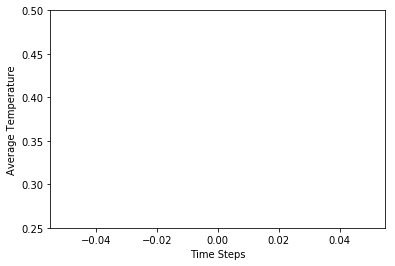

In [21]:
plt.plot(np.arange(its),arrT)
plt.xlabel("Time Steps")
plt.ylabel("Average Temperature")
plt.ylim([0.25,0.5])
plt.savefig('avtemp.pdf')

**Compare quantities from Jarvis 1993**

In [22]:
f = annulus.radialLengths[0] / annulus.radialLengths[1]
TavPred = 1. / (1. + f**-0.75)
TavPred
print("For f=%.2f, Jarvis 93 predict t_av = %.2f" %(f,TavPred) )
print("Modelled t_av = %.2f" %np.average(tField.data[:]))

For f=0.30, Jarvis 93 predict t_av = 0.29
Modelled t_av = 0.30


In [23]:
D = 2. * np.pi
# Number of up-wellings
n = 3
# Aspect parameter, defined by Jarvis 93
A =  (np.pi/2./n)*(1.+f)/(1.-f)
print("Apect parameter used here is A=%.2f, compared to Jarvis A=1" %A)
print("For A=1 and f = 0.3, Jarvis found Nu=8.65")

Apect parameter used here is A=0.97, compared to Jarvis A=1
For A=1 and f = 0.3, Jarvis found Nu=8.65


In [24]:
tgrad = fn.math.dot(tField.fn_gradient,annulus.fn_unitvec_radial())
tSurf_integral  = uw.utils.Integral( mesh=annulus, fn=tgrad, integrationType="surface", surfaceIndexSet=outer )
surf_integral   = uw.utils.Integral( mesh=annulus, fn=1.0, integrationType="surface", surfaceIndexSet=outer )
Nu = np.log(f)/(1.-f)* tSurf_integral.evaluate()[0] / surf_integral.evaluate()[0]
print("From our model, Nu = %.2f" %Nu)

From our model, Nu = 8.23


The average temperatures are close to that of Jarvis 1993. Our Nu is about a quarter of theirs, which can be expected from the contrast in boundary conditions


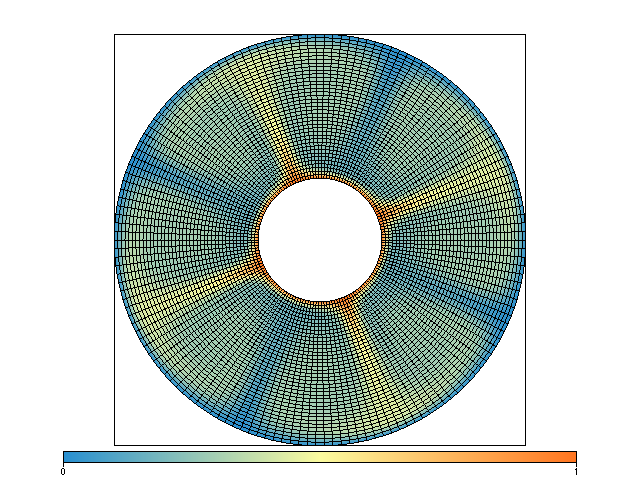

In [25]:
fig.show()


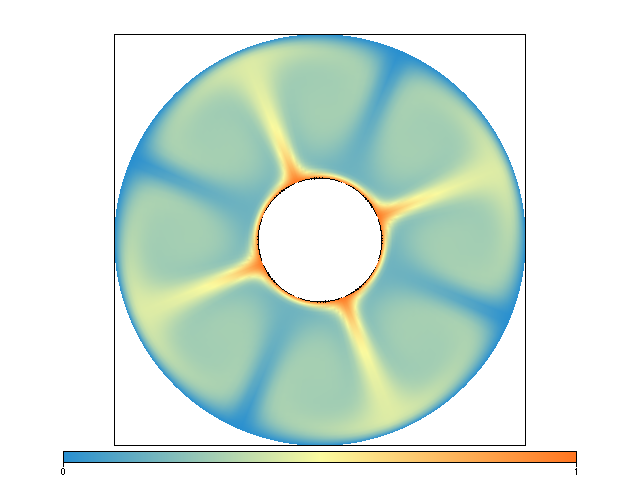

'temperature.png'

In [26]:
figV = glucifer.Figure(**fig)
figV.append(glucifer.objects.Surface(annulus, tField,onMesh=True))

figV.append(glucifer.objects.VectorArrows(annulus, vField / Ra  * 1.0e2 , onMesh=True,arrowHead = 0.3))

figV.show()
figV.save_image('temperature.png')

In [27]:
# Save data for restart

# mH = annulus.save("Jarvis93data/mesh.h5")
# tF = tField.save('Jarvis93data/temp.h5',mH)
# vF = vField.save('Jarvis93data/vel.h5',mH)
# vField.xdmf('Jarvis93data/vel.xdmf',vF,'vel', mH, 'mesh')